# Import necessary modules

In [1]:
!pip install -U imbalanced-learn
!pip install gensim

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm

# gensim
import gensim
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument

# Metrics
from sklearn import utils
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Requirement already up-to-date: imbalanced-learn in /opt/conda/lib/python3.6/site-packages (0.7.0)


## Split the dataset 

In [2]:
df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

X = df.Transcript
y = df.PHQ_Binary.to_numpy()

In [3]:
RANDOM_STATE = 42 # lucky number

X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

X_train_val_raw.shape, X_test_raw.shape

((144,), (37,))

## Label sentences

In [4]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [5]:
X_train_val_labeled = label_sentences(X_train_val_raw, 'train_val')
X_test_labeled = label_sentences(X_test_raw, 'test')
all_data = X_train_val_labeled + X_test_labeled

all_data[:10]

[TaggedDocument(words=['yeah', 'i', 'great', 'you', 'uh', 'los', 'angeles', 'california', 'uh', 'i', 'like', 'diversity', 'i', 'feel', 'la', 'itself', 'country', 'much', 'much', 'explore', 'uh', 'nothing', 'like', 'it', 'traffic', 'uh', 'i', 'would', 'say', 'traffic', 'real', 'estate', 'prices', 'kinda', 'crazy', 'compared', 'rest', 'country', 'you', 'know', 'it', 'fine', 'i', 'traveled', 'um', 'i', 'traveled', 'bit', 'um', 'i', 'would', 'like', 'travel', 'though', 'i', 'traveled', 'i', 'countries', 'um', 'i', 'i', 'say', 'europe', 'continent', 'um', 'i', 'uh', 'london', 'um', 'i', 'born', 'my', 'familys', 'nigeria', 'i', 'nigeria', 'times', 'i', 'denmark', 'um', 'amsterdam', 'i', 'uh', 'else', 'i', 'gone', 'uh', 'germany', 'um', 'i', 'think', 'i', 'think', 'it', 'yeah', 'think', 'it', 'yeah', 'exploring', 'uh', 'exploring', 'exploring', 'new', 'places', 'um', 'seeing', 'new', 'things', 'meeting', 'new', 'people', 'different', 'culture', 'it', 'definitely', 'um', 'um', 'gives', 'you', 

# Train doc2vec model
Parameters:
* dm=0: distributed bag of words (DBOW) is used
* vector_size=300: 300 vector dimensional feature vectors
* negative=5: specifies how many "noise words" should be drawn
* min_count=1: ignores all words with total frequency lower than this
* alpha=0.065: the initial learning rate

In [6]:
model_dbow = doc2vec.Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 181/181 [00:00<00:00, 568240.29it/s]


In [7]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), 
                     total_examples=len(all_data), 
                     epochs=1)  #shuffle the data and use all data exactly once
    model_dbow.alpha -= 0.002 #set the learning rate
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 181/181 [00:00<00:00, 177251.70it/s]


In [8]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

X_train_val = get_vectors(model_dbow, len(X_train_val_labeled), 300, 'train_val')
X_test = get_vectors(model_dbow, len(X_test_labeled), 300, 'test')

In [9]:
# the ratio of minority class to majority class will be 1 after resampling
us = RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)

X_train_val, y_train_val = us.fit_sample(X_train_val, y_train_val)

X_train_val.shape, X_test.shape

((88, 300), (37, 300))

# More preprocessing

## Evaluation metrics
Some considerations in evaluation metrics when deciding our model.
1. In our use case, it is more important to have high sensitivity as want to correctly identify as many depression cases out of all actual depression cases for early intervention. Predicting a non-depressed person as depressed is comparatively less severe, meaning we prioritize TPR (sensitivity) over FPR.
2. Hence we will focus on `f1 score` and `recall` for the positive class.

Note:
* Sensitivity = true positive rate = recall = TP / (TP + FN)
* Specificity = true negative rate = TN / (TN + FP)
* Fall out = false positive rate = FP / (FP + TN)
* Miss rate = false negative rate = FN / (FN + TP)

Metrics can be found on this [website](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [10]:
def evaluate_on_training_set(y_test, y_pred):
    print(y_pred)
    print(y_test)
    
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

## k cross 

In [11]:
def k_cross(model, X=X_train_val, y=y_train_val, k=10, n=1, random_state=RANDOM_STATE):
    f1_scores = []
    recall_scores = []
    rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=RANDOM_STATE)
    for train_index, val_index in rkf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train) 
        
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        f1_scores.append(f1)
        recall = recall_score(y_val, y_pred)
        recall_scores.append(recall)
        
    return f1_scores, recall_scores

## Evaluate model

In [12]:
def evaluate_model(model):
    model.fit(X_train_val, y_train_val)
    y_pred = model.predict(X_test)
    evaluate_on_training_set(y_test, y_pred)
    
    return model

# Model Implementation

## Logistic Regression 

In [13]:
def find_best_logreg_model(power):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for i in range(power + 1):
        model = LogisticRegression(n_jobs=3, C=10**i)
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"power: {i}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"power: {i}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_logreg_f1_model, best_logreg_recall_model = find_best_logreg_model(6)

power: 0: f1 = 0.4640692640692641 > best f1 = -1
power: 0: recall = 0.4708333333333333 > best recall = -1


[1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.6520979020979021
              precision    recall  f1-score   support

           0       0.83      0.58      0.68        26
           1       0.42      0.73      0.53        11

    accuracy                           0.62        37
   macro avg       0.63      0.65      0.61        37
weighted avg       0.71      0.62      0.64        37

Confusion Matrix: 
 [[15 11]
 [ 3  8]]


LogisticRegression(C=1, n_jobs=3)

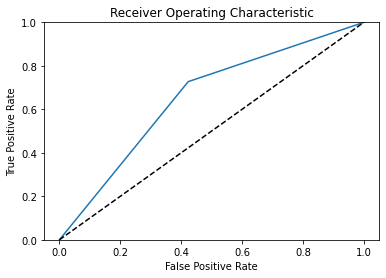

In [14]:
# Based on f1
evaluate_model(best_logreg_f1_model)

[1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.6520979020979021
              precision    recall  f1-score   support

           0       0.83      0.58      0.68        26
           1       0.42      0.73      0.53        11

    accuracy                           0.62        37
   macro avg       0.63      0.65      0.61        37
weighted avg       0.71      0.62      0.64        37

Confusion Matrix: 
 [[15 11]
 [ 3  8]]


LogisticRegression(C=1, n_jobs=3)

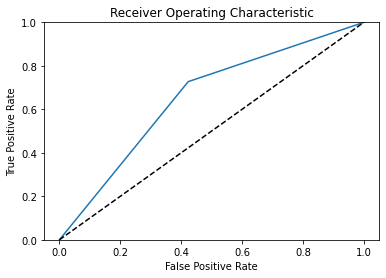

In [15]:
# Based on recall
evaluate_model(best_logreg_recall_model)

## Decision Tree

In [16]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            
            f1_scores, recall_scores = k_cross(model)
            f1 = np.mean(f1_scores)
            recall = np.mean(recall_scores)
            
            if f1 > best_f1:
                print(f"depth: {depth}, leaf: {leaf}: f1 = {f1} > best f1 = {best_f1}")
                best_f1 = f1
                best_f1_model = model
                
            if recall > best_recall:
                print(f"depth: {depth}, leaf: {leaf}: recall = {recall} > best recall = {best_recall}")
                best_recall = recall
                best_recall_model = model
    
    return best_f1_model, best_recall_model

best_tree_f1_model, best_tree_recall_model = find_best_tree_model(20, 30)

depth: 1, leaf: 1: f1 = 0.4391575091575091 > best f1 = -1
depth: 1, leaf: 1: recall = 0.5116666666666666 > best recall = -1
depth: 1, leaf: 26: f1 = 0.4716971916971917 > best f1 = 0.4391575091575091
depth: 1, leaf: 26: recall = 0.5583333333333333 > best recall = 0.5116666666666666


[0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.43356643356643354
              precision    recall  f1-score   support

           0       0.60      0.23      0.33        26
           1       0.26      0.64      0.37        11

    accuracy                           0.35        37
   macro avg       0.43      0.43      0.35        37
weighted avg       0.50      0.35      0.34        37

Confusion Matrix: 
 [[ 6 20]
 [ 4  7]]


DecisionTreeClassifier(max_depth=1, min_samples_leaf=26, random_state=42)

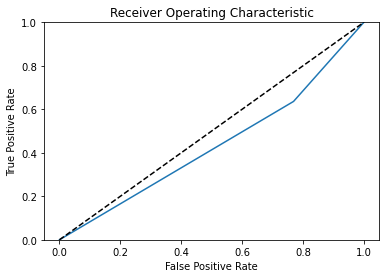

In [17]:
# Based on f1
evaluate_model(best_tree_f1_model)

[0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.43356643356643354
              precision    recall  f1-score   support

           0       0.60      0.23      0.33        26
           1       0.26      0.64      0.37        11

    accuracy                           0.35        37
   macro avg       0.43      0.43      0.35        37
weighted avg       0.50      0.35      0.34        37

Confusion Matrix: 
 [[ 6 20]
 [ 4  7]]


DecisionTreeClassifier(max_depth=1, min_samples_leaf=26, random_state=42)

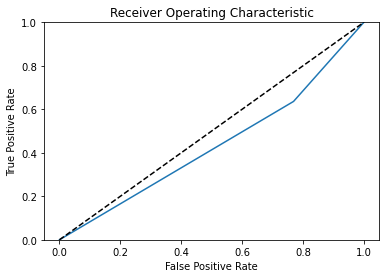

In [18]:
# Based on recall
evaluate_model(best_tree_recall_model)

## Random Forest

In [19]:
def find_best_forest_model(n_estimators):
    best_f1_model = None
    best_recall_model = None
    best_f1 = -1
    best_recall = -1
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=estimator) 
        
        f1_scores, recall_scores = k_cross(model)
        f1 = np.mean(f1_scores)
        recall = np.mean(recall_scores)

        if f1 > best_f1:
            print(f"estimator: {estimator}: f1 = {f1} > best f1 = {best_f1}")
            best_f1 = f1
            best_f1_model = model

        if recall > best_recall:
            print(f"estimator: {estimator}: recall = {recall} > best recall = {best_recall}")
            best_recall = recall
            best_recall_model = model
    
    return best_f1_model, best_recall_model

best_forest_f1_model, best_forest_recall_model = find_best_forest_model(30)

estimator: 1: f1 = 0.4808441558441559 > best f1 = -1
estimator: 1: recall = 0.5933333333333334 > best recall = -1
estimator: 11: f1 = 0.48434343434343435 > best f1 = 0.4808441558441559


[1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.472027972027972
              precision    recall  f1-score   support

           0       0.67      0.31      0.42        26
           1       0.28      0.64      0.39        11

    accuracy                           0.41        37
   macro avg       0.47      0.47      0.40        37
weighted avg       0.55      0.41      0.41        37

Confusion Matrix: 
 [[ 8 18]
 [ 4  7]]


RandomForestClassifier(n_estimators=11, random_state=42)

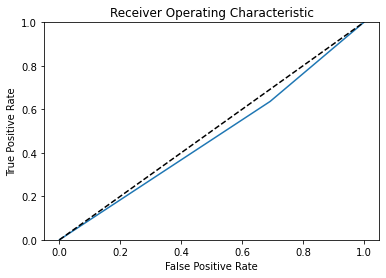

In [20]:
# Based on f1
evaluate_model(best_forest_f1_model)

[0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0 0 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.38111888111888115
              precision    recall  f1-score   support

           0       0.57      0.31      0.40        26
           1       0.22      0.45      0.29        11

    accuracy                           0.35        37
   macro avg       0.39      0.38      0.35        37
weighted avg       0.47      0.35      0.37        37

Confusion Matrix: 
 [[ 8 18]
 [ 6  5]]


RandomForestClassifier(n_estimators=1, random_state=42)

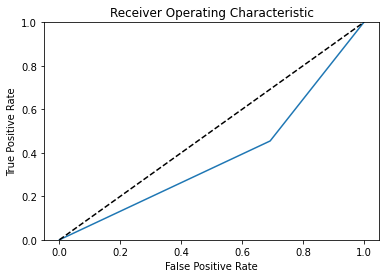

In [21]:
# Based on recall
evaluate_model(best_forest_recall_model)

## SVM with grid search

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 151 tasks      | elapsed:    0.9s


[1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1]
[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
AUC is:  0.6206293706293707
              precision    recall  f1-score   support

           0       0.85      0.42      0.56        26
           1       0.38      0.82      0.51        11

    accuracy                           0.54        37
   macro avg       0.61      0.62      0.54        37
weighted avg       0.71      0.54      0.55        37

Confusion Matrix: 
 [[11 15]
 [ 2  9]]
Best SVM parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    1.1s finished


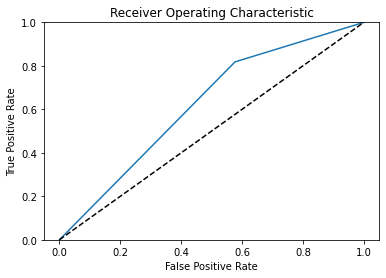

In [22]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

svm_model_cv = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='f1', verbose=1, n_jobs=4)

best_svm_model = evaluate_model(svm_model_cv)
print(f"Best SVM parameters: {best_svm_model.best_params_}")